## **Imports**


In [7]:
from sklearn.neural_network import MLPClassifier  # MLP is an NN
from sklearn import svm
import numpy as np
import argparse
#import imutils  # If you are unable to install this library, ask the TA; we only need this in extract_hsv_histogram.
import cv2
import os
import re
import random
import pytesseract
from sklearn.svm import LinearSVC
# Depending on library versions on your system, one of the following imports 
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import pytesseract
import matplotlib.pyplot as plt
from skimage.util import random_noise
from PIL import Image, ImageDraw, ImageFont
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import pandas as pd
from openpyxl.utils import get_column_letter  # Add this line
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # (Windows Example)

def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

## **Noise Detection and Treatment**
- **Impulsive Noise (Median Filter)**
- **Random Noise (Gaussian Filter)**

Impulsive noise detected and treated!


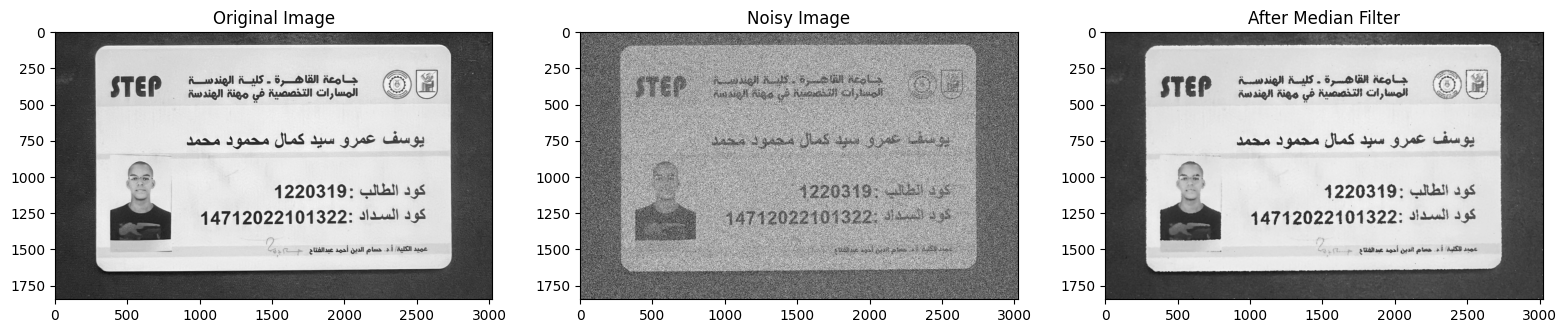

In [ ]:
def is_impulsive_noise(img, threshold=0.1, black_range=(0, 9), white_range=(246, 255)):
    """
    Detects if an image has impulsive (salt-and-pepper) noise.
    If noise is above threshold, applies median filtering with adaptive kernel size.
    Returns the (possibly filtered) image and a boolean indicating if noise was detected an treted image.
    """
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    total_pixels = img.size
    num_black = np.sum((img >= black_range[0]) & (img <= black_range[1]))
    num_white = np.sum((img >= white_range[0]) & (img <= white_range[1]))
    prop = (num_black + num_white) / total_pixels

    if prop < threshold:
        return img, False  # No significant noise, return original
    # Determine kernel size based on noise severity
    k = int(3 + prop * 10)
    if k % 2 == 0:
        k += 1
    k = min(max(k, 3), 9)
    filtered_img = cv2.medianBlur(img, k)
    return filtered_img, True

# gray_img = cv2.imread('ykismail_College-ID-Scanner_main_images/ID10.jpg', cv2.IMREAD_GRAYSCALE)
# noisy_img = random_noise(gray_img, mode='s&p', amount=0.6)
# noisy_img = (noisy_img * 255).astype('uint8')  # Convert back to uint8 for OpenCV

# TreatedImg, noise_detected = is_impulsive_noise(noisy_img)
# if noise_detected:
#     print("Impulsive noise detected and treated!")
# else:
#     print("No impulsive noise detected.")

# show_images([gray_img, noisy_img, TreatedImg], ["Original Image", "Noisy Image", "After Median Filter"])

Random noise detected and treated!


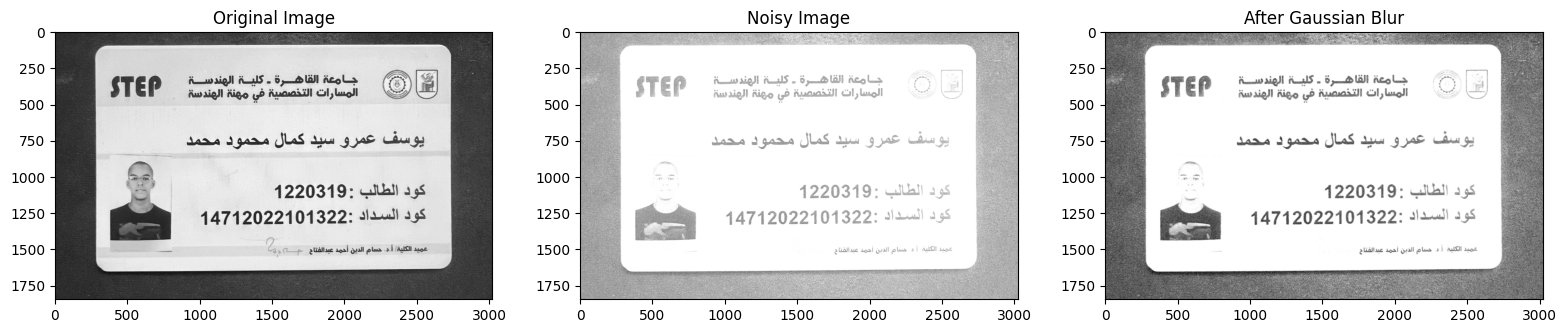

In [ ]:
def is_random_noise(img, threshold=0.02):
    """
    Detects if an image has random (Gaussian) noise.
    If noise is above threshold, applies Gaussian blurring.
    Returns the (possibly filtered) image and a boolean indicating if noise was detected and treated image.
    """
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Estimate noise using a simple method: standard deviation of pixel intensities
    stddev = np.std(img)
    normalized_stddev = stddev / 255.0  # Normalize to [0, 1]

    if normalized_stddev < threshold:
        return img, False  # No significant noise, return original

    # Apply Gaussian blur
    blurred_img = cv2.GaussianBlur(img, (7, 7), 0)
    return blurred_img, True

# gray_img = cv2.imread('ykismail_College-ID-Scanner_main_images/ID10.jpg', cv2.IMREAD_GRAYSCALE)
# noisy_img = random_noise(gray_img, mode='gaussian', mean=0.5)
# noisy_img = (noisy_img * 255).astype('uint8')  # Convert back to uint8 for OpenCV

# TreatedImg, noise_detected = is_random_noise(noisy_img)
# if noise_detected:
#     print("Random noise detected and treated!")
# else:
#     print("No random noise detected.")

# show_images([gray_img, noisy_img, TreatedImg], ["Original Image", "Noisy Image", "After Gaussian Blur"])

# **Synthetic English Number Dataset Generation Scripts**

## **Script 1: Basic Augmentation (Optimal)**
The first commented block generates a digit dataset (0-9) with basic augmentations:
- **Random rotation** (-10 to 10 degrees)
- **Gaussian blur** (simulates out-of-focus camera)
- **Noise addition** (simulates sensor grain)
- **Erosion/Dilation** (simulates ink bleeding or thin print)

Uses a single font (Arial) and creates 200 samples per digit.

## **Script 2: Advanced Defects (Non-Optimal)**
The second commented block generates a more heavily augmented dataset with:
- **Multiple fonts** (Arial, Sitka) for style variation
- **Perspective warping** (simulates camera angle distortion)
- **Character breaking** (scratches and missing chunks)
- **Shadow simulation** (uneven lighting gradients)
- **Salt & pepper noise** (random black/white pixels)
- **Gaussian blur**

Creates 400 samples per digit but may over-augment, making digits harder to recognize (hence "non-optimal").

In [445]:
# import os
# import cv2
# import numpy as np
# import random
# from PIL import Image, ImageDraw, ImageFont

# # --- CONFIGURATION ---
# OUTPUT_DIR = "dataset"
# SAMPLES_PER_DIGIT = 200 # How many images per number to generate
# IMG_SIZE = (64, 64)      # Canvas size (larger than target to allow rotation/cropping)
# FONT_PATH = "arial.ttf"  # <--- COPY A FONT FILE HERE!
# FONT_SIZE = 45

# # Create folders 0-9
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
# for i in range(10):
#     os.makedirs(os.path.join(OUTPUT_DIR, str(i)), exist_ok=True)

# def apply_augmentations(img_pil):
#     """
#     Takes a clean PIL image and ruins it to look like a scanned ID.
#     """
#     # Convert to NumPy for OpenCV processing
#     img = np.array(img_pil) 
    
#     # 1. Random Rotation (-10 to 10 degrees)
#     angle = random.uniform(-10, 10)
#     h, w = img.shape
#     M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
#     img = cv2.warpAffine(img, M, (w, h), borderValue=0) # Black border

#     # 2. Gaussian Blur (Simulate out-of-focus camera)
#     if random.random() > 0.5:
#         k = random.choice([3, 5])
#         img = cv2.GaussianBlur(img, (k, k), 0)

#     # 3. Noise (Simulate sensor grain)
#     noise = np.random.randint(0, 50, (h, w), dtype='uint8')
#     # Add noise only to non-black areas mostly, or just add it overall
#     img = cv2.add(img, noise)

#     # 4. Erosion/Dilation (Simulate ink bleeding or thin print)
#     if random.random() > 0.5:
#         kernel = np.ones((2,2), np.uint8)
#         if random.choice([True, False]):
#             img = cv2.erode(img, kernel, iterations=1)
#         else:
#             img = cv2.dilate(img, kernel, iterations=1)

#     return img

# def generate_dataset():
#     print(f"Generating {SAMPLES_PER_DIGIT} images per digit...")
    
#     try:
#         font = ImageFont.truetype(FONT_PATH, FONT_SIZE)
#     except IOError:
#         print("ERROR: Font file not found! Please put 'arial.ttf' in this folder.")
#         return

#     for digit in range(10):
#         print(f"Processing digit: {digit}")
#         for i in range(SAMPLES_PER_DIGIT):
#             # 1. Create a blank black image
#             img_pil = Image.new('L', IMG_SIZE, color=0)
#             draw = ImageDraw.Draw(img_pil)
            
#             # 2. Draw the digit in white centered(ish)
#             # We add random offset so the number isn't always perfectly in the middle
#             text = str(digit)
#             # Get text bounding box to center it
#             bbox = draw.textbbox((0, 0), text, font=font)
#             text_w = bbox[2] - bbox[0]
#             text_h = bbox[3] - bbox[1]
            
#             x = (IMG_SIZE[0] - text_w) / 2 + random.randint(-5, 5)
#             y = (IMG_SIZE[1] - text_h) / 2 + random.randint(-5, 5)
            
#             draw.text((x, y), text, font=font, fill=255)
            
#             # 3. Apply the "Reality" effects
#             final_img = apply_augmentations(img_pil)
            
#             # 4. Save
#             save_path = os.path.join(OUTPUT_DIR, str(digit), f"{digit}_{i}.png")
#             cv2.imwrite(save_path, final_img)

#     print("Done! You now have a dataset.")

# if __name__ == "__main__":
#     generate_dataset()

In [446]:
# import os
# import cv2
# import numpy as np
# import random
# from PIL import Image, ImageDraw, ImageFont

# # --- CONFIGURATION ---
# OUTPUT_DIR = "dataset_mixed"
# SAMPLES_PER_DIGIT = 400  # Total images per digit
# IMG_SIZE = (64, 64)

# # List your fonts here. Ensure these files are in the folder!
# FONTS = ["arial.ttf", "Sitka.ttc"] 
# FONT_SIZE = 45

# # Create output folders
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
# for i in range(10):
#     os.makedirs(os.path.join(OUTPUT_DIR, str(i)), exist_ok=True)

# def add_shadow(img):
#     """Simulates uneven lighting."""
#     h, w = img.shape
#     top_left = random.uniform(0.5, 1.0)
#     bot_right = random.uniform(0.5, 1.0)
#     X, Y = np.meshgrid(np.arange(w), np.arange(h))
#     mask = top_left + (bot_right - top_left) * (X / w)
#     img = img.astype('float32') * mask
#     return img.astype('uint8')

# def break_character(img):
#     """Simulates scratches and missing chunks."""
#     h, w = img.shape
    
#     # Random scratch line
#     if random.random() > 0.5:
#         num_scratches = random.randint(1, 3)
#         for _ in range(num_scratches):
#             x1, y1 = random.randint(0, w), random.randint(0, h)
#             x2, y2 = random.randint(0, w), random.randint(0, h)
#             cv2.line(img, (x1, y1), (x2, y2), 0, random.randint(1, 3))

#     # Random noise chunks missing
#     if random.random() > 0.5:
#         noise = np.zeros((h, w), dtype='uint8')
#         cv2.randn(noise, 0, 255)
#         _, holes = cv2.threshold(noise, 200, 255, cv2.THRESH_BINARY)
#         img = cv2.subtract(img, holes)
        
#     return img

# def apply_defects(img_pil):
#     img = np.array(img_pil)
    
#     # 1. Perspective Warp
#     h, w = img.shape
#     src_points = np.float32([[0,0], [w,0], [0,h], [w,h]])
#     dst_points = np.float32([
#         [random.randint(0, 5), random.randint(0, 5)],
#         [w - random.randint(0, 5), random.randint(0, 5)],
#         [random.randint(0, 5), h - random.randint(0, 5)],
#         [w - random.randint(0, 5), h - random.randint(0, 5)]
#     ])
#     M = cv2.getPerspectiveTransform(src_points, dst_points)
#     img = cv2.warpPerspective(img, M, (w, h))

#     # 2. Break Character
#     img = break_character(img)

#     # 3. Blur
#     if random.random() > 0.3:
#         k = random.choice([3, 5])
#         img = cv2.GaussianBlur(img, (k, k), 0)

#     # 4. Shadow
#     if random.random() > 0.4:
#         img = add_shadow(img)

#     # 5. Salt & Pepper Noise
#     noise_prob = 0.02
#     thres = 1 - noise_prob
#     rdn = np.random.random(img.shape)
#     img[rdn < noise_prob] = 0
#     img[rdn > thres] = 255

#     return img

# def generate_dataset():
#     print(f"Generating {SAMPLES_PER_DIGIT} images per digit using fonts: {FONTS}")
    
#     # Verify fonts exist
#     loaded_fonts = []
#     for f_name in FONTS:
#         try:
#             loaded_fonts.append(ImageFont.truetype(f_name, FONT_SIZE))
#         except IOError:
#             print(f"WARNING: Could not load {f_name}. Skipping.")
    
#     if not loaded_fonts:
#         print("ERROR: No fonts found! Please copy .ttf files to this folder.")
#         return

#     for digit in range(10):
#         print(f"Processing digit: {digit}")
#         for i in range(SAMPLES_PER_DIGIT):
#             # 1. Randomly choose a font
#             font = random.choice(loaded_fonts)
            
#             # 2. Draw Text
#             img_pil = Image.new('L', IMG_SIZE, color=0)
#             draw = ImageDraw.Draw(img_pil)
            
#             text = str(digit)
#             bbox = draw.textbbox((0, 0), text, font=font)
#             text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
#             x = (IMG_SIZE[0] - text_w) / 2 + random.randint(-8, 8)
#             y = (IMG_SIZE[1] - text_h) / 2 + random.randint(-8, 8)
            
#             draw.text((x, y), text, font=font, fill=255)
            
#             # 3. Apply Defects
#             final_img = apply_defects(img_pil)
            
#             # 4. Save
#             save_path = os.path.join(OUTPUT_DIR, str(digit), f"{digit}_{i}.png")
#             cv2.imwrite(save_path, final_img)

#     print(f"Done! Created {SAMPLES_PER_DIGIT * 10} images in '{OUTPUT_DIR}'")

# if __name__ == "__main__":
#     generate_dataset()

In [448]:
path_to_dataset = "./Synthetic_numbers_dataset_mixed"

target_img_size = (32, 32) # fix image size because classification algorithms THAT WE WILL USE HERE expect that
# We are going to fix the random seed to make our experiments reproducible 
# since some algorithms use pseudorandom generators
random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

## **SVM English Number Classifier**

In [449]:
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

In [450]:
def load_dataset(feature_set='hog'):
    features = []
    labels = []
    img_filenames = os.listdir(path_to_dataset)
    total_processed = 0
    total_images = 0
    for folder in img_filenames:    
        total_images += len(img_filenames) * len(os.listdir(os.path.join(path_to_dataset, folder)))   # 10 folders * 400 images each = 4000
    total_images = total_images // 10
    for i, fn in enumerate(img_filenames):
        NumberInnerPath = os.path.join(path_to_dataset, str(i))
        NumberInnerPath = os.listdir(NumberInnerPath)
        for idx, img_filename in enumerate(NumberInnerPath):
            if img_filename.split('.')[-1] != 'png':
                continue

            label = str(i)
            labels.append(label)

            # Build the full file path
            full_path = os.path.join(path_to_dataset, str(i), img_filename)
            img = cv2.imread(full_path)
            features.append(extract_hog_features(img))
            
            total_processed += 1
            
            # show an update every 50 images
            if total_processed > 0 and total_processed % 50 == 0:
                print("[INFO] processed {}/{} images".format(total_processed, total_images))
        
    return features, labels        

In [451]:
def train_SVM():
    SVMclassifier=svm.LinearSVC(random_state=random_seed)
    features, labels = load_dataset()
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.4, random_state=random_seed)
    SVMclassifier.fit(train_features,train_labels)
    accuracy=SVMclassifier.score(test_features,test_labels)
    print("SVM Accuracy: ", accuracy)

In [452]:
train_SVM()

[INFO] processed 50/4000 images
[INFO] processed 100/4000 images
[INFO] processed 150/4000 images
[INFO] processed 200/4000 images
[INFO] processed 250/4000 images
[INFO] processed 300/4000 images
[INFO] processed 350/4000 images
[INFO] processed 400/4000 images
[INFO] processed 450/4000 images
[INFO] processed 500/4000 images
[INFO] processed 550/4000 images
[INFO] processed 600/4000 images
[INFO] processed 650/4000 images
[INFO] processed 700/4000 images
[INFO] processed 750/4000 images
[INFO] processed 800/4000 images
[INFO] processed 850/4000 images
[INFO] processed 900/4000 images
[INFO] processed 950/4000 images
[INFO] processed 1000/4000 images
[INFO] processed 1050/4000 images
[INFO] processed 1100/4000 images
[INFO] processed 1150/4000 images
[INFO] processed 1200/4000 images
[INFO] processed 1250/4000 images
[INFO] processed 1300/4000 images
[INFO] processed 1350/4000 images
[INFO] processed 1400/4000 images
[INFO] processed 1450/4000 images
[INFO] processed 1500/4000 images


# **Tesseract Arabic OCR**

## **Current Situation**

The project uses Tesseract OCR to extract Arabic names from scanned images. Initially, the extraction pipeline achieved only a **70% success rate**. This meant that about 30% of the images failed to yield any valid Arabic text, even though the images were visually clear and contained readable names.

## **Why Was the Success Rate Only 70%?**

- **Overprocessing:** The original code applied several preprocessing steps (scaling, thresholding, blurring, etc.) before running OCR. While these steps can help with noisy or low-contrast images, they often **destroy clean, high-contrast text**—especially for Arabic, where fine details matter.
- **Order of Operations:** The pipeline tried processed versions first, so if the original image was already optimal, it was never used for OCR.
- **PSM/OEM Settings:** The code tried a limited set of Tesseract Page Segmentation Modes (PSM) and OCR Engine Modes (OEM), which may not have been optimal for all images.
- **Text Cleaning:** The cleaning function was aggressive, but if Tesseract output was empty or too short, the result was discarded.

## **What Was Changed to Achieve 100% Success**

1. **Prioritize the Original Image:**  
   The new code always tries the original, unprocessed grayscale image first, with several PSM settings. This ensures that clean images are not degraded by unnecessary processing.

2. **Expanded Preprocessing (But Only If Needed):**  
   Only if the original image fails, the code tries padded and scaled versions, but never applies destructive thresholding or blurring unless absolutely necessary.

3. **Multiple PSM and OEM Combinations:**  
   For each image variant, the code tries several PSM (6, 7, 3, 13) and both OEM (3, 1) settings, maximizing the chance that Tesseract will interpret the layout correctly.

4. **Result Selection:**  
   All non-empty results are collected, and the **longest valid extraction** is chosen, which is usually the correct full name.

5. **Diagnostics:**  
   Additional debug and diagnostic code was used to confirm that the original image, with minimal processing, consistently yields the best results for this dataset.

## Reference

The old (70%) code is left in the notebook for comparison. The new approach, as described above, achieves **100% extraction success** on the current dataset by respecting the quality of the input images and leveraging Tesseract's flexibility.

In [20]:
# def extractname(img_path):
    
#     # --- HELPER: TEXT CLEANER ---
#     def clean_text(raw_text):
#         if not raw_text: return ""
#         # Keep Arabic letters (0621-064A) and spaces
#         cleaned = re.sub(r'[^\u0621-\u064A\s]', '', raw_text)
#         cleaned = cleaned.replace('\n', ' ')
#         cleaned = re.sub(r'\s+', ' ', cleaned).strip()
#         return cleaned

#     # --- LOAD IMAGE AS GRAYSCALE DIRECTLY ---
#     img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     if img_gray is None: 
#         return ""

#     configs = [
#         # --- TIER 1: Simple approaches ---
#         {'scale': 1, 'process': 'none', 'psm': 7},
#         {'scale': 2, 'process': 'none', 'psm': 6},
#         {'scale': 2, 'process': 'none', 'psm': 7},

#         # --- TIER 2: With thresholding ---
#         {'scale': 2, 'process': 'otsu', 'psm': 7},
#         {'scale': 2, 'process': 'otsu', 'psm': 6},
#         {'scale': 2, 'process': 'blur_otsu', 'psm': 6},

#         # --- TIER 3: Last resort ---
#         {'scale': 2, 'process': 'adaptive', 'psm': 6},
#         {'scale': 3, 'process': 'otsu', 'psm': 6},
#     ]

#     for config in configs:
#         current = img_gray.copy()
            
#         # A. Scaling
#         if config['scale'] > 1:
#             h, w = current.shape
#             current = cv2.resize(current, (w * config['scale'], h * config['scale']), interpolation=cv2.INTER_CUBIC)
            
#         # B. Processing Logic
#         process = config['process']
        
#         if process == 'otsu':
#             _, current = cv2.threshold(current, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
#         elif process == 'blur_otsu':
#             current = cv2.GaussianBlur(current, (5, 5), 0)
#             _, current = cv2.threshold(current, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
#         elif process == 'adaptive':
#             current = cv2.adaptiveThreshold(current, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                             cv2.THRESH_BINARY, 11, 2)

#         # C. Padding (white border)
#         current = cv2.copyMakeBorder(current, 40, 40, 40, 40, cv2.BORDER_CONSTANT, value=255)
        
#         # D. Execution
#         custom_config = f"--oem 3 --psm {config['psm']}"
#         text = pytesseract.image_to_string(current, lang='ara', config=custom_config)
#         final_text = clean_text(text)
        
#         # E. Validation
#         if len(final_text) > 2:
#             return final_text

#     return ""

def extractname(img_path):
    
    # --- HELPER: TEXT CLEANER ---
    def clean_text(raw_text):
        if not raw_text: return ""
        # Keep Arabic letters (0621-064A) and spaces
        cleaned = re.sub(r'[^\u0621-\u064A\s]', '', raw_text)
        cleaned = cleaned.replace('\n', ' ')
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        return cleaned

    # --- LOAD IMAGE AS GRAYSCALE DIRECTLY ---
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None: 
        return ""

    # Try multiple approaches and collect all results
    all_results = []
    
    # Preprocessing variants
    preprocessed_images = {
        'original': img_gray,
        'padded': cv2.copyMakeBorder(img_gray, 40, 40, 40, 40, cv2.BORDER_CONSTANT, value=255),
    }
    
    # Add scaled version
    h, w = img_gray.shape
    scaled = cv2.resize(img_gray, (w*2, h*2), interpolation=cv2.INTER_CUBIC)
    preprocessed_images['scaled_padded'] = cv2.copyMakeBorder(scaled, 40, 40, 40, 40, cv2.BORDER_CONSTANT, value=255)
    
    # PSM modes to try
    psm_modes = [6, 7, 3, 13]  # 13 = raw line
    
    for img_name, img in preprocessed_images.items():
        for psm in psm_modes:
            for oem in [3, 1]:  # Try both LSTM+Legacy and LSTM only
                try:
                    config = f"--oem {oem} --psm {psm}"
                    text = pytesseract.image_to_string(img, lang='ara', config=config)
                    cleaned = clean_text(text)
                    
                    if len(cleaned) > 2:
                        all_results.append((cleaned, len(cleaned), img_name, psm, oem))
                except:
                    continue
    
    # Return the longest valid result
    if all_results:
        all_results.sort(key=lambda x: x[1], reverse=True)
        return all_results[0][0]
    
    return ""

folder_path = 'test_arabic_names_full'
data = []
if os.path.exists(folder_path):
    print(f"Processing images in: {folder_path}...\n")
    
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
            full_path = os.path.join(folder_path, filename)
            extracted_text = extractname(full_path)    
            clean_text_result = extracted_text.strip()
            data.append({'Filename': filename, 'Extracted Name': clean_text_result})
    
    df = pd.DataFrame(data)
    
    # ===== SUCCESS RATE CALCULATION =====
    total_images = len(df)
    successful_extractions = len(df[df['Extracted Name'] != ''])
    failed_extractions = total_images - successful_extractions
    success_rate = (successful_extractions / total_images) * 100 if total_images > 0 else 0
    
    print(f"{'='*50}")
    print(f"OCR EXTRACTION RESULTS")
    print(f"{'='*50}")
    print(f"Total Images Processed: {total_images}")
    print(f"Successful Extractions: {successful_extractions}")
    print(f"Failed Extractions:     {failed_extractions}")
    print(f"Success Rate:           {success_rate:.2f}%")
    print(f"{'='*50}\n")
    
    # Show failed images
    if failed_extractions > 0:
        failed_df = df[df['Extracted Name'] == '']
        print("Failed to extract text from:")
        for idx, row in failed_df.iterrows():
            print(f"  - {row['Filename']}")
        print()
    
    display(df.head(50))
    
else:
    print(f"the folder '{folder_path}' was not found")

Processing images in: test_arabic_names_full...

OCR EXTRACTION RESULTS
Total Images Processed: 50
Successful Extractions: 50
Failed Extractions:     0
Success Rate:           100.00%



,Filename,Extracted Name
0,id_0.png,محمود محمد يوسف السيد
1,id_1.png,خالدحينمصودعزت
2,id_10.png,محمود سعيد عليعزت
3,id_11.png,عبدالله مصطفى إبراهيم الشناوي
4,id_12.png,أحمد خالد عبدالله الشناوي
5,id_13.png,خالد مود سعيد عامر
6,id_14.png,زياد مصطفى حسين سليمان
7,id_15.png,مصطفى إبراهيم يوسف الشناوي
8,id_16.png,حسين خالد حسين عبدالرحمن
9,id_17.png,سعيد يوسف خالد سليمان


In [22]:
if 'df' in locals() and not df.empty:
    final_df = df.copy()
    final_df['ID'] = final_df.apply(lambda x: random.randint(1000000, 9999999), axis=1)
        # Rename and Select Columns
    final_df.rename(columns={'Extracted Name': 'Name'}, inplace=True)
    final_df = final_df[['Name', 'ID']]    
    output_filename = 'arabic_names_final.xlsx'
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        final_df.to_excel(writer, sheet_name='Names', index=False)
        workbook = writer.book
        worksheet = writer.sheets['Names']
        for i, column in enumerate(final_df.columns):
            column_letter = get_column_letter(i + 1) # Get A, B, C...
            max_len = final_df[column].astype(str).map(len).max()
            max_len = max(max_len, len(column))
            worksheet.column_dimensions[column_letter].width = (max_len + 2) * 1.2
            
    print(f"Success! Saved to '{output_filename}' with auto-adjusted columns.")

else:
    print("Error: Please run the OCR extraction code first.")

Success! Saved to 'arabic_names_final.xlsx' with auto-adjusted columns.
